# collect all data to one dataframe:


In [ ]:
import sqlite3
import json
import pandas as pd

# Define the path to your SQLite database file
#db_path = "/mnt/c/Users/vikto/OneDrive - Høgskulen på Vestlandet/Master_teams_privat/results/Optuna_data_bases/non_seasonal/all_data_non_seasonal_cut_off_F_clear_win_F_trails800_F1/lite_optuna.db"
#db_path = "/mnt/c/Users/vikto/OneDrive - Høgskulen på Vestlandet/Master_teams_privat/results/Optuna_data_bases/non_seasonal/all_data_non_seasonal_cut_off_T_clear_win_F_trails800_F1/lite_optuna.db"
#db_path = "/mnt/c/Users/vikto/OneDrive - Høgskulen på Vestlandet/Master_teams_privat/results/Optuna_data_bases/seasonal/all_data_seasonal_cut_off_F_clear_win_F_trails800_F1/lite_optuna.db"
#db_path = "/mnt/c/Users/vikto/OneDrive - Høgskulen på Vestlandet/Master_teams_privat/results/Optuna_data_bases/seasonal/all_data_seasonal_cut_off_T_clear_win_F_trails800_F1/lite_optuna.db"

#Andreas path
#db_path = "data/lite_optuna_no_cut_off.db"
db_path = "data/lite_optuna_with_cut_off.db"


# Open connection
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Retrieve all studies with their IDs and names
cursor.execute("SELECT study_id, study_name FROM studies")
studies = cursor.fetchall()

results = []

# Process each study
for study in studies:
    study_id, study_name = study
    # Retrieve all trial IDs for the current study
    cursor.execute("SELECT trial_id FROM trials WHERE study_id = ?", (study_id,))
    trial_ids = cursor.fetchall()
    
    # Process each trial in the study
    for trial_id_tuple in trial_ids:
        trial_id = trial_id_tuple[0]
        
        # Retrieve the objective value (from trial_values) for this trial, if it exists.
        cursor.execute("SELECT value FROM trial_values WHERE trial_id = ?", (trial_id,))
        trial_value_result = cursor.fetchone()
        trial_value = trial_value_result[0] if trial_value_result else None
        
        # Retrieve the "predictions" attribute (from trial_user_attributes)
        cursor.execute(
            "SELECT value_json FROM trial_user_attributes WHERE trial_id = ? AND key = ?",
            (trial_id, "predictions")
        )
        pred_result = cursor.fetchone()
        if pred_result:
            try:
                predictions = json.loads(pred_result[0])
            except Exception:
                predictions = pred_result[0]
        else:
            predictions = None
        
        # Retrieve the "Confussion matrix" attribute (from trial_user_attributes)
        cursor.execute(
            "SELECT value_json FROM trial_user_attributes WHERE trial_id = ? AND key = ?",
            (trial_id, "Confussion matrix")
        )
        cm_result = cursor.fetchone()
        if cm_result:
            try:
                confusion_matrix = json.loads(cm_result[0])
            except Exception:
                confusion_matrix = cm_result[0]
        else:
            confusion_matrix = None
        
        # Retrieve hyperparameter configuration (from trial_params)
        cursor.execute(
            "SELECT param_name, param_value, distribution_json FROM trial_params WHERE trial_id = ?",
            (trial_id,)
        )
        params_result = cursor.fetchall()
        if params_result:
            # Map parameter names to their values. (You can also parse distribution_json if needed.)
            hyperparameters = {row[0]: row[1] for row in params_result}
        else:
            hyperparameters = None
        
        # Append the trial data to results
        results.append({
            "study_id": study_id,
            "study_name": study_name,
            "trial_id": trial_id,
            "trial_value": trial_value,
            "predictions": predictions,
            "confusion_matrix": confusion_matrix,
            "hyperparameters": hyperparameters
        })

conn.close()

# Create a DataFrame from the results
df_all = pd.DataFrame(results)
print(df_all)

# preprocess the DataFrame
# Create a new column 'detector' by extracting the algorithm name from study_name
# Define the detector names to look for
detector_names = [
    "BayesianNonparametricDetectionMethod",
    "DiscriminativeDriftDetector2019",
    "SemiParametricLogLikelihood",
    "KullbackLeiblerDistanceDetector", 
    "JensenShannonDistanceDetector",
    "HellingerDistanceDetector"
]

# Function to extract detector name from study_name
def extract_detector(study_name):
    for detector in detector_names:
        if detector in study_name:
            return detector
    return "Unknown"

# Apply the function to create the detector column
df_all['detector'] = df_all['study_name'].apply(extract_detector)





In [ ]:
df_all['detector'] = df_all['detector'].replace({
    "BayesianNonparametricDetectionMethod": "BNDM",
    "DiscriminativeDriftDetector2019": "D3",
    "SemiParametricLogLikelihood": "SPLL",
    "KullbackLeiblerDistanceDetector": "KLD",
    "JensenShannonDistanceDetector": "JSD",
    "HellingerDistanceDetector": "HD"
})

df_all['detector'] = df_all['detector'].astype('category')

# Display a sample of BNDM detector records
filtered_df = df_all[df_all['detector'] == 'BNDM']
filtered_df.head(10)


# make parallell coordinate plot

In [ ]:
import pandas as pd 
import plotly.graph_objects as go
import plotly.express as px

fig_width = 1600
fig_height = 500
margin = dict(l=80, r=80, t=80, b=80)

# ----------------------------
# 3. Create a Custom Colorscale from a Plotly Palette
# ----------------------------
# Use Plotly Express's sequential Viridis palette.
colors = px.colors.sequential.Blues  
# Convert the list of hex colors into a continuous colorscale.
custom_colorscale = [[i / (len(colors) - 1), color] for i, color in enumerate(colors)]

# ----------------------------
# 4. Plotting per Detector with Custom Colorscale
# ----------------------------
detector_groups = df_all.groupby('detector')

for detector, group in detector_groups:
    # Expand the hyperparameters dictionary into separate columns.
    hyper_df = group['hyperparameters'].apply(pd.Series)
    hyper_df['trial_value'] = group['trial_value'].values
    
    # Identify hyperparameter columns (exclude 'trial_value').
    hyper_cols = [col for col in hyper_df.columns if col != 'trial_value']
    
    # Build dimension dictionaries for each hyperparameter.
    # Set label to empty since we'll add custom annotations below.
    dimensions = []
    for col in hyper_cols:
        col_min = hyper_df[col].min()
        col_max = hyper_df[col].max()
        dimensions.append(
            dict(
                range=[col_min, col_max],
                label='',
                values=hyper_df[col]
            )
        )
    
    # Create the Parallel Coordinates plot using the custom colorscale.
    fig = go.Figure(
        data=go.Parcoords(
            line=dict(
                color=hyper_df['trial_value'],
                colorscale=custom_colorscale,  # Apply the Plotly palette-based colorscale.
                cmin=hyper_df['trial_value'].min(),
                cmax=hyper_df['trial_value'].max(),
                showscale=True
            ),
            dimensions=dimensions
        )
    )
    
    # ----------------------------
    # 5. Adding Custom Annotations for Labels
    # ----------------------------
    # Create custom annotations for each hyperparameter, positioned below the plot.
    num_dims = len(hyper_cols)
    annotations = []
    for i, col in enumerate(hyper_cols):
        x_pos = i / (num_dims - 1) if num_dims > 1 else 0.5
        annotations.append(
            dict(
                x=x_pos,
                y=-0.1,  # Adjust the y value to fine-tune the vertical position.
                xref="paper",
                yref="paper",
                text=col,
                showarrow=False,
                font=dict(size=12),
                xanchor="center"
            )
        )
    
    # ----------------------------
    # 6. Final Layout Adjustments
    # ----------------------------
    fig.update_layout(
        title=f"Parallel Coordinates for Detector: {detector}",
        plot_bgcolor='white',
        paper_bgcolor='white',
        width=fig_width,
        height=fig_height,
        margin=margin,
        annotations=annotations
    )
    
    # Save the figure to an HTML file and display it.
    fig.write_html(f"parallel_coords_{detector}.html")
    fig.show()

In [ ]:
import pandas as pd 
import plotly.graph_objects as go
import plotly.express as px

# Example settings (adjust as needed)
fig_width = 1600
fig_height = 500
margin = dict(l=80, r=80, t=80, b=80)

# ----------------------------
# 3. Create a Custom Colorscale from a Plotly Palette
# ----------------------------
# Using Plotly Express's sequential Blues palette.
colors = px.colors.sequential.Blues  
custom_colorscale = [[i / (len(colors) - 1), color] for i, color in enumerate(colors)]

# ----------------------------
# 4. Plotting per Detector with Custom Colorscale
# ----------------------------
detector_groups = df_all.groupby('detector')

for detector, group in detector_groups:
    # Expand the hyperparameters dictionary into separate columns.
    hyper_df = group['hyperparameters'].apply(pd.Series)
    hyper_df['trial_value'] = group['trial_value'].values
    
    # Identify hyperparameter columns (exclude 'trial_value').
    hyper_cols = [col for col in hyper_df.columns if col != 'trial_value']
    
    # Build dimension dictionaries for each hyperparameter.
    dimensions = []
    for col in hyper_cols:
        col_min = hyper_df[col].min()
        col_max = hyper_df[col].max()
        dimensions.append(
            dict(
                range=[col_min, col_max],
                label='',
                values=hyper_df[col]
            )
        )
    
    # Create the Parallel Coordinates plot with the main trace.
    fig = go.Figure(
        data=go.Parcoords(
            line=dict(
                color=hyper_df['trial_value'],
                colorscale=custom_colorscale,  # Use custom color scale.
                cmin=hyper_df['trial_value'].min(),
                cmax=hyper_df['trial_value'].max(),
                showscale=True
            ),
            dimensions=dimensions
        )
    )
    
    # ----------------------------
    # 5. Adding Custom Annotations for Labels
    # ----------------------------
    num_dims = len(hyper_cols)
    annotations = []
    for i, col in enumerate(hyper_cols):
        x_pos = i / (num_dims - 1) if num_dims > 1 else 0.5
        annotations.append(
            dict(
                x=x_pos,
                y=-0.1,  # Adjust vertical position.
                xref="paper",
                yref="paper",
                text=col,
                showarrow=False,
                font=dict(size=12),
                xanchor="center"
            )
        )
    
    # ----------------------------
    # 6. Add the Best Combination as an Extra Red Line
    # ----------------------------
    best_idx = hyper_df['trial_value'].idxmin()  
    best_row = hyper_df.loc[best_idx]

    best_dimensions = []
    # Build dimensions for the best line. Each dimension gets a single-value list.
    for col in hyper_cols:
        best_value = best_row[col]
        best_dimensions.append(
            dict(
                range=[hyper_df[col].min(), hyper_df[col].max()],
                label='',
                values=[best_value]
            )
        )

    # Add the best combination trace in red.
    # Note: The 'width' parameter is removed because it's not supported in go.Parcoords.
    fig.add_trace(go.Parcoords(
        line=dict(
            color='red'
        ),
        dimensions=best_dimensions
    ))
    
    # ----------------------------
    # 7. Final Layout Adjustments
    # ----------------------------
    fig.update_layout(
        title=f"Parallel Coordinates for Detector: {detector}",
        plot_bgcolor='white',
        paper_bgcolor='white',
        width=fig_width,
        height=fig_height,
        margin=margin,
        annotations=annotations
    )
    
    # Save the figure to an HTML file and display it.
    fig.write_html(f"parallel_coords_{detector}.html")
    fig.show()


# Collect the best trials from all studies and store it in a df in memory

In [ ]:
import sqlite3
import json
import pandas as pd

# Define the path to your SQLite database file
#db_path = "/mnt/c/Users/vikto/OneDrive - Høgskulen på Vestlandet/Master_teams_privat/results/Optuna_data_bases/non_seasonal/all_data_non_seasonal_cut_off_F_clear_win_F_trails800_F1/lite_optuna.db"
#db_path = "/mnt/c/Users/vikto/OneDrive - Høgskulen på Vestlandet/Master_teams_privat/results/Optuna_data_bases/non_seasonal/all_data_non_seasonal_cut_off_T_clear_win_F_trails800_F1/lite_optuna.db"

# Open connection
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Retrieve all studies with their IDs and names
cursor.execute("SELECT study_id, study_name FROM studies")
studies = cursor.fetchall()

results = []

# Process each study
for study in studies:
    study_id, study_name = study
    # Get the best performing trial for the current study
    cursor.execute(
        """
        SELECT t.trial_id, tv.value
        FROM trial_values tv
        JOIN trials t ON tv.trial_id = t.trial_id
        WHERE t.study_id = ?
        ORDER BY tv.value DESC
        LIMIT 1
        """,
        (study_id,)
    )
    best_trial = cursor.fetchone()
    
    if best_trial:
        trial_id, best_value = best_trial
        
        # Retrieve the "predictions" attribute (from trial_user_attributes)
        cursor.execute(
            "SELECT value_json FROM trial_user_attributes WHERE trial_id = ? AND key = ?",
            (trial_id, "predictions")
        )
        pred_result = cursor.fetchone()
        if pred_result:
            try:
                predictions = json.loads(pred_result[0])
            except Exception as e:
                predictions = pred_result[0]
        else:
            predictions = None

        # Retrieve the "Confussion matrix" attribute (from trial_user_attributes)
        cursor.execute(
            "SELECT value_json FROM trial_user_attributes WHERE trial_id = ? AND key = ?",
            (trial_id, "Confussion matrix")
        )
        cm_result = cursor.fetchone()
        if cm_result:
            try:
                confusion_matrix = json.loads(cm_result[0])
            except Exception as e:
                confusion_matrix = cm_result[0]
        else:
            confusion_matrix = None

        # Retrieve hyperparameter configuration (from trial_params)
        cursor.execute(
            "SELECT param_name, param_value, distribution_json FROM trial_params WHERE trial_id = ?",
            (trial_id,)
        )
        params_result = cursor.fetchall()
        if params_result:
            # Create a dictionary mapping parameter names to their values.
            # You can also parse distribution_json if needed.
            hyperparameters = {row[0]: row[1] for row in params_result}
        else:
            hyperparameters = None

        results.append({
            "study_id": study_id,
            "study_name": study_name,
            "trial_id": trial_id,
            "best_value": best_value,
            "predictions": predictions,
            "confusion_matrix": confusion_matrix,
            "hyperparameters": hyperparameters
        })
    else:
        # In case no trial is found for the study
        results.append({
            "study_id": study_id,
            "study_name": study_name,
            "trial_id": None,
            "best_value": None,
            "predictions": None,
            "confusion_matrix": None,
            "hyperparameters": None
        })

conn.close()

# Create a DataFrame from the results
df_best = pd.DataFrame(results)
detector_names = [
    "BayesianNonparametricDetectionMethod",
    "DiscriminativeDriftDetector2019",
    "SemiParametricLogLikelihood",
    "KullbackLeiblerDistanceDetector", 
    "JensenShannonDistanceDetector",
    "HellingerDistanceDetector"
]

# Function to extract detector name from study_name
def extract_detector(study_name):
    for detector in detector_names:
        if detector in study_name:
            return detector
    return "Unknown"

# Apply the function to create the detector column
df_best['detector'] = df_best['study_name'].apply(extract_detector)

df_best['detector'] = df_best['detector'].replace({
    "BayesianNonparametricDetectionMethod": "BNDM",
    "DiscriminativeDriftDetector2019": "D3",
    "SemiParametricLogLikelihood": "SPLL",
    "KullbackLeiblerDistanceDetector": "KLD",
    "JensenShannonDistanceDetector": "JSD",
    "HellingerDistanceDetector": "HD"
})

df_best['detector'] = df_best['detector'].astype('category')


df_best.head()


Ny versjon av den over

In [ ]:
import sqlite3
import json
import pandas as pd

# ─────────────────────────────────────────────────────────────
# 1. database location
# ─────────────────────────────────────────────────────────────
db_path = "data/lite_optuna_seasonal_cut_f_lpd.db"   

# ─────────────────────────────────────────────────────────────
# 2. helper
# ─────────────────────────────────────────────────────────────
def fetch_json_attr(cur, trial_id: int, key: str):
    """Return JSON-decoded trial_user_attributes.key (or raw text)."""
    cur.execute(
        "SELECT value_json FROM trial_user_attributes "
        "WHERE trial_id = ? AND key = ?",
        (trial_id, key)
    )
    row = cur.fetchone()
    if not row:
        return None
    try:
        return json.loads(row[0])
    except Exception:
        return row[0]

# ─────────────────────────────────────────────────────────────
# 3. grab **all** trials
# ─────────────────────────────────────────────────────────────
results = []

with sqlite3.connect(db_path) as conn:
    cur = conn.cursor()

    # every study
    cur.execute("SELECT study_id, study_name FROM studies")
    for study_id, study_name in cur.fetchall():

        # >>> ALL trials for this study <<<
        cur.execute(
            """
            SELECT t.trial_id, tv.value
            FROM trial_values tv
            JOIN trials t ON tv.trial_id = t.trial_id
            WHERE t.study_id = ?
            """,
            (study_id,)
        )
        for trial_id, obj_value in cur.fetchall():

            # user attributes we care about
            confusion_matrix = fetch_json_attr(cur, trial_id, "Confussion matrix")
            cut_off          = fetch_json_attr(cur, trial_id, "Cut off")
            accuracy         = fetch_json_attr(cur, trial_id, "accuracy")
            accuracy_ht_dd         = fetch_json_attr(cur, trial_id, "acc (ht-dd)")
            f1_score         = fetch_json_attr(cur, trial_id, "f1")
            lpd_ht           = fetch_json_attr(cur, trial_id, "lpd (ht)")
            preds            = fetch_json_attr(cur, trial_id, "predictions")

            # hyper-parameters
            cur.execute(
                "SELECT param_name, param_value FROM trial_params WHERE trial_id = ?",
                (trial_id,)
            )
            hyperparams = {n: v for n, v in cur.fetchall()} or None

            results.append({
                "study_id"        : study_id,
                "study_name"      : study_name,
                "trial_id"        : trial_id,
                "objective_value" : obj_value,
                "confusion_matrix": confusion_matrix,
                "cut_off"         : cut_off,
                "accuracy"        : accuracy,
                "accuracy_ht_dd" : accuracy_ht_dd,
                "f1"              : f1_score,
                "lpd (ht)"        : lpd_ht,
                "predictions"     : preds,
                "hyperparameters" : hyperparams
            })

# ─────────────────────────────────────────────────────────────
# 4. dataframe + quick detector label
# ─────────────────────────────────────────────────────────────
df_all = pd.DataFrame(results)

detector_names = {
    "BayesianNonparametricDetectionMethod": "BNDM",
    "DiscriminativeDriftDetector2019":       "D3",
    "SemiParametricLogLikelihood":           "SPLL",
    "KullbackLeiblerDistanceDetector":       "KLD",
    "JensenShannonDistanceDetector":         "JSD",
    "HellingerDistanceDetector":             "HD"
}

def extract_detector(name):
    for long, short in detector_names.items():
        if long in name:
            return short
    return "Unknown"

df_all["detector"] = df_all["study_name"].apply(extract_detector).astype("category")

# ─────────────────────────────────────────────────────────────
# 5. write to CSV (skip `predictions` if present)
# ─────────────────────────────────────────────────────────────
output_path = "data/output/all_trials.csv"
(df_all
   .drop(columns=["predictions"], errors="ignore")
   .to_csv(output_path, index=False))

print(f"\nDataFrame with ALL trials saved to {output_path}")


In [ ]:
output_path = "data/output/best_trials.csv"

(df_best            # original frame
     .drop(columns=['predictions'], errors='ignore')  # ignore if missing
     .to_csv(output_path, index=False)
)

print(f"\nDataFrame saved to {output_path}")


# Plot the drifts from the df with the original data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load the synthetic drift data ---
#df_original = pd.read_csv("/home/viktor/projects/UnsupervisedConceptDriftDetection/datasets/files/synthetic_drift_20_years_non_season.csv")
df_original = pd.read_csv("data/synthetic_drift_20_years_non_season.csv")
data_df = df_best

def plot_drift_points(drifts, study_name):
    # --- Plot drift points for each study ---

    plt.figure(figsize=(25, 5))
    plt.xlabel('Time (years)')
    plt.ylabel("label")
    plt.title(f'{study_name}')
    plt.plot(df_original.index/17520, df_original["class"], label='ground truth', color="lightblue", alpha=0.8,marker='o', markersize=0.5)
    plt.fill_between(df_original.index/17520, df_original["class"], color='lightblue', alpha=1)
    plt.scatter([x/17520 for x in drifts], df_original.loc[drifts]["class"], color='red', label='Drift detected', s=10, zorder=5)
    plt.yticks([0, 1])
    plt.xticks(range(0, int(df_original.index.max()/17520)+1))
    plt.legend()
    plt.yticks([0, 1], ['no drift', 'drift'])

for i in range(len(df_best)):
    #print(df.iloc[i])
    predictions = df_best.iloc[i]['predictions']
    drifts = []
    for drift_pair in predictions:
        if drift_pair[1] == 1:
            drifts.append(drift_pair[0])
    plot_drift_points(drifts, df_best.iloc[i]['detector'])


# MAKE STREK PLOT 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# --- Load the synthetic drift data ---
#df_original = pd.read_csv("/home/viktor/projects/UnsupervisedConceptDriftDetection/datasets/files/synthetic_drift_20_years_non_season.csv")
df_original = pd.read_csv("data/synthetic_drift_20_years_non_season.csv")
# Assume df_best is already defined with 6 rows, each containing 'predictions' and 'detector' columns

# Create a figure with 3 rows and 2 columns of subplots
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
axs = axs.flatten()  # Flatten to iterate easily

for i in range(len(df_best)):
    predictions = df_best.iloc[i]['predictions']
    # Extract drift points where the second element equals 1
    drifts = [drift_pair[0] for drift_pair in predictions if drift_pair[1] == 1]
    
    ax = axs[i]
    ax.set_xlabel('Time (years)', fontsize=20)
    ax.set_ylabel("label", fontsize=20)
    ax.set_title(f"{df_best.iloc[i]['detector']}", fontsize=20)
    
    # Plot ground truth with thicker line and larger markers
    ax.plot(df_original.index / 17520, df_original["class"],
            label='ground truth', color="lightblue", alpha=0.8,
            marker='o', markersize=5, linewidth=5)
    ax.fill_between(df_original.index / 17520, df_original["class"],
                    color='lightblue', alpha=1)
    
    # Plot the detected drifts as red points with increased size
    ax.scatter([x / 17520 for x in drifts], df_original.loc[drifts]["class"],
               color='red', label='Drift detected', s=50, zorder=5)
    
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # Set ticks and labels for y-axis and x-axis
    ax.set_yticks([0, 1])
    ax.set_xticks(range(0, int(df_original.index.max() / 17520) + 1))
    ax.set_yticklabels(['no drift', 'drift'])

# Create custom legend handles with thicker lines
ground_line = mlines.Line2D([], [], color="lightblue", marker="o",
                              markersize=16, label="ground truth", linewidth=3)
drift_scatter = mlines.Line2D([], [], color="red", marker="o", linestyle="None",
                              markersize=16, label="Drift detected")

# Add a common legend for all subplots
fig.legend(handles=[ground_line, drift_scatter], loc='upper right', ncol=2, fontsize=25)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
import pandas as pd
df = pd.read_csv("data/output/all_trials.csv")
 
# the column names you care about confusion_matrix,accuracy,f1,
lpd_col = 'lpd (ht)'
f1_col  = 'f1'
acc_col = 'accuracy'
 
# make sure they’re floats (and skip any rows with missing values)
def corr_pair(group, x, y):
    s = group[[x, y]].dropna().astype(float)
    if len(s) > 1:
        return float('nan')
    return s[x].corr(s[y])

rows = []
for det, group in df.groupby('detector'):
    rows.append({
        'detector': det,
        'corr_lpd_f1':  corr_pair(group, lpd_col, f1_col),
        'corr_lpd_acc': corr_pair(group, lpd_col, acc_col)
    })
 
summary_df = pd.DataFrame(rows).set_index('detector')
 
print(summary_df)

In [ ]:
import pandas as pd
import numpy as np   # only for np.nan

df = pd.read_csv("data/output/all_trials.csv")

# ---- check what’s really in the frame ----------------------
# print("Columns in CSV:", df.columns.tolist())   # helpful sanity-check

# ---- columns we want ---------------------------------------
lpd_col = 'lpd (ht)' 
f1_col  = 'f1'
acc_col = 'accuracy'
acc_ht_dd_col = 'accuracy_ht_dd'


# ---- helper ------------------------------------------------
def corr_pair(group: pd.DataFrame, x: str, y: str) -> float:
    """
    Pearson r between columns `x` and `y` inside `group`.
    Returns NaN if fewer than 2 complete rows.
    """
    s = group[[x, y]].dropna().astype(float)
    if len(s) < 2:          # need at least two points
        return np.nan
    return s[x].corr(s[y])

# ---- per-detector correlations -----------------------------
rows = []
for det, grp in df.groupby('detector'):
    rows.append({
        'detector':      det,
        'corr_lpd_f1':   corr_pair(grp, lpd_col, f1_col),
        'corr_acc_f1':   corr_pair(grp, acc_col, f1_col),
        'corr_lpd_acc':  corr_pair(grp, lpd_col, acc_col),
        'corr_acc_ht_dd_col_f1': corr_pair(grp, acc_ht_dd_col, f1_col),
        'corr_acc_ht_dd_col_lpd': corr_pair(grp, acc_ht_dd_col, lpd_col),
        'corr_acc_ht_dd_col_acc': corr_pair(grp, acc_ht_dd_col, acc_col)
    })

summary_df = (pd.DataFrame(rows)
                .set_index('detector')
                .sort_index())

print("\nCorrelation summary:")
print(summary_df)


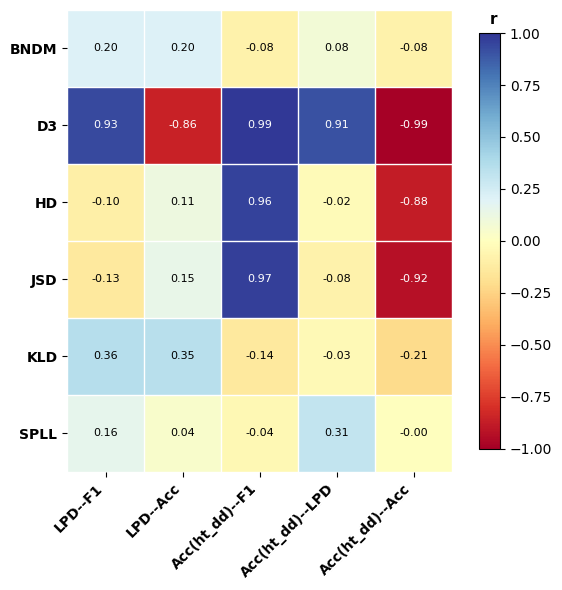

In [87]:
"""
Visualising a correlation summary in five different ways.

Works with:
  • matplotlib (heat-map, bar plots, scatter plots)
  • pandas Styler (colour-graded HTML table)
  • plotly (interactive dashboard)

Author: your-name-here
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

# ------------------------------------------------------------------
# 0.  Example data  (replace with your own DataFrame if you like)
# ------------------------------------------------------------------
data_non_seasonal = {
    'Detector': ['BNDM','D3','HD','JSD','KLD','SPLL'],
    'LPD--F1': [0.494412,-0.035559,-0.070109,0.097213,0.166945,0.505561],
    #'Acc-F1': [0.348312,-0.613226,-0.671026,-0.369313,-0.756457,0.441345],
    'LPD--Acc': [0.621287,0.232496,0.088573,0.105051,-0.054456,0.229621],
    'Acc(ht_dd)--F1': [0.194346,0.709677,0.840107,0.639296,0.910122,0.444140],
    'Acc(ht_dd)--LPD': [-0.470275,-0.158889,-0.030301,-0.004976,0.121189,0.521182],
    'Acc(ht_dd)--Acc': [-0.618679,-0.978349,-0.924478,-0.935913,-0.925793,-0.318114]
}
data = { # Seasonal
    "Detector": ["BNDM", "D3", "HD", "JSD", "KLD", "SPLL"],
    "LPD--F1": [0.204236, 0.930911, -0.096078, -0.133280, 0.357567, 0.158833],
    # "Acc-F1": [1.000000, -0.961578, -0.902005, -0.895953, 0.985133, 0.666194],
    "LPD--Acc": [0.204224, -0.859186, 0.112577, 0.145137, 0.345232, 0.043514],
    "Acc(ht_dd)--F1": [-0.084713, 0.992148, 0.955572, 0.966380, -0.135005, -0.044344],
    "Acc(ht_dd)--LPD": [0.084731, 0.912836, -0.024105, -0.083274, -0.034478, 0.309993],
    "Acc(ht_dd)--Acc": [-0.084704, -0.987769, -0.879600, -0.922491, -0.213777, -0.004672],
}

corr_df = pd.DataFrame(data).set_index('Detector')

## ------------------------------------------------------------------
# 1.  Modern annotated heat-map  (red = positive, blue = negative)
# ------------------------------------------------------------------
def show_heatmap(df, annotate=True, cmap='RdYlBu'):
    import matplotlib.pyplot as plt
    import numpy as np

    # — Create the figure —
    fig, ax = plt.subplots(figsize=(14, 6), facecolor="white")
    im = ax.imshow(df.values,
                   vmin=-1, vmax=1,
                   cmap=cmap,
                   aspect='equal',
                   interpolation='nearest')

    # — Colour-bar on the right —
    #cbar = fig.colorbar(im, ax=ax, shrink=0.85, pad=0.02)
    # — Colour-bar on the right —
    cbar = fig.colorbar(im, ax=ax, shrink=0.9, pad=0.02)

    # put the label in the usual style first …
    cbar.set_label('r', rotation=0, fontsize=11,
               labelpad=15, weight='bold')      # labelpad still controls left–right offset

    # … then nudge it *along* the bar:  x = 0.5 (centre),  y = 1.03 (just above top)
    cbar.ax.yaxis.set_label_coords(0.7 , 1.05)


    # — Tick labels —
    
    # — Tick labels —
    ax.set_xticks(np.arange(df.shape[1]))
    ax.set_xticklabels(df.columns,
                   rotation=45, ha='right',
                   fontsize=10, fontweight='bold')   #  ← HERE

    ax.set_yticks(np.arange(df.shape[0]))
    ax.set_yticklabels(df.index,
                   fontsize=10, fontweight='bold')   #  ← AND HERE


    # — Light grid to separate cells —
    ax.set_xticks(np.arange(-.5, df.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, df.shape[0], 1), minor=True)
    ax.grid(which='minor', color='white', linewidth=1)
    ax.tick_params(which='minor', bottom=False, left=False)

    # — Remove spines for a cleaner look —
    for spine in ax.spines.values():
        spine.set_visible(False)

    # — Optional numeric annotations —
    if annotate:
        data = df.values
        for i in range(df.shape[0]):
            for j in range(df.shape[1]):
                val = data[i, j]
                txt_color = "white" if abs(val) > 0.5 else "black"
                ax.text(j, i, f"{val:.2f}",
                        ha="center", va="center",
                        fontsize=8, color=txt_color)

    plt.tight_layout()
    plt.show()



# ------------------------------------------------------------------
# Example runner
# ------------------------------------------------------------------
if __name__ == "__main__":
    # Quick demo (comment out as desired)
    show_heatmap(corr_df)
